In [1]:
# settings

# Датасет UCID, на котором в статье считали вероятность коллизий
# Скачать можно по ссылке http://jasoncantarella.com/downloads/ucid.v2.tar.gz
# При распаковке архива выскакивает ошибка, возможно, часть файлов в нем битая
ucid_dataset_path = './data/ucid/ucid.v2/'

In [16]:
# imports

# python packages
import imageio
import cv2
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, img_as_float, color, io
from scipy.spatial.distance import hamming
import os # для загрузки датасета с диска
import timeit
import imagehash
from PIL import Image
#import random
import matplotlib.pyplot as plt
import seaborn as sns
# our packages
import  tucker_hash as tHash
import numpy as np
import seaborn as sns

In [3]:
import importlib
importlib.reload(tHash)

<module 'tucker_hash' from '/home/marti/Projects/nla_project_image_hash/src/tucker_hash.py'>

In [4]:
def preprocessing(image,size = (256,256)):
    demo_im = resize(image, size, anti_aliasing=True)
    #print(io.imshow(demo_im))
    L = color.rgb2lab(demo_im)[:,:,0]
    #print(io.imshow(L))
    blur = cv2.GaussianBlur(L,(5,5),0)
    #print(io.imshow(blur))
    return blur

#print(preprocessing(image).shape)

In [5]:
def make_dataset(path, size=None):
    """
    Загружает датасет с диска.
  
    Parameters
    ----------
    path : os.path
        относительный путь до директории с картинками. 
        в директории не должно быть вложенных директорий и посторонних файлов
    size : int
        максимально количество загружаемых картинок.
        если не указан, загружаются все картинки
  
    Returns
    -------
    dataset_ndarr : tuple of L-images (for our has-function)
    dataset_PIL: tuple of PIL instances (for imagehash functions)
  
    """
    img_idx = 0
    dataset_ndarr = [None]*size
    dataset_PIL = [None]*size
    for name in os.listdir(path):
        if (size is not None) and (img_idx >= size):
            break
        
        full_name = os.path.join(path, name)
        dataset_ndarr[img_idx] = io.imread(full_name) # можно переделать preprocessing(), чтобы он принимал PIL instances
        dataset_PIL[img_idx] = Image.open(full_name)
        img_idx += 1
        
    return tuple(dataset_ndarr), tuple(dataset_PIL)


In [6]:
def paired_h_distance(hash_list):
    if isinstance(hash_list[0], np.ndarray) is False:
        hash_list = [i.hash.flatten().astype('int') for i in hash_list]
    p_dist = np.zeros(shape=len(hash_list)*(len(hash_list) - 1) // 2, dtype='float')
    
    counter = 0
    for i in range(len(hash_list)-1):
        for j in range(i+1, len(hash_list)):
            p_dist[counter] = hamming(hash_list[i], hash_list[j]) * len(hash_list[j])
            counter += 1
    
    return p_dist

In [7]:
def make_hash_list(dataset_prepared, hasher, **hasher_kwargs):
    """
    Make hashes for any image from dataset 
  
    Parameters
    ----------
    dataset_prepared : array
        list of L-images
    hasher : array (*function) (image, **hasher_kwargs)
        name of hash function
    hasher_kwargs : dict
        kwargs for hasher
  
    Returns
    -------
    hash_list : array
    time_gen_all_hashes, [s] : float
    time_gen_1_hash, [s]: float
  
    """
    dataset_size = len(dataset_prepared)
    hash_list = [None]*dataset_size
    
    time_start = timeit.default_timer() 
    
    for img_idx, img in enumerate(dataset_prepared):
        hash_list[img_idx] = hasher(img, **hasher_kwargs)
    
    time_end = timeit.default_timer() 
    time_gen_all_hashes = time_end - time_start    #плохой способ мерять время исполнения.
    time_gen_1_hash = time_gen_all_hashes / dataset_size
    
    return hash_list, time_gen_all_hashes, time_gen_1_hash


# TODO
def get_collision_prob(hash_list, collision_dist_thd, name='output', sample_n=1000):
    """
    Measure a probability of collisions
  
    Parameters
    ----------
    hash_list : array
        list of hashes
    thd : int
        discance high treshold for collision
  
    Returns
    -------
    collision_prob : float 
  
    """
    p_dist = paired_h_distance(hash_list)
    p_size = len(p_dist)
    collision_prob = dict(((i, list()) for i in collision_dist_thd))
    for i in range(sample_n):
        choise_r = np.random.choice(p_dist, replace=True, size=len(p_dist))
        for i in collision_prob:
            collision_prob[i].append(len(choise_r[choise_r < i]) / p_size)
    
    for i in collision_prob:
        collision_prob[i] = np.mean(collision_prob[i])
    
    plt.figure(figsize=(20, 10))
    sns_plot = sns.distplot(p_dist)
    sns_plot.set_title(name)
    sns_plot.figure.savefig("./data/{}.png".format(name))
    sns_plot.plot()
    
    temp_df = pd.DataFrame.from_dict(collision_prob, orient='index').reset_index()
    temp_df.columns = ['Порог', 'Вероятность коллизии']
    
    fig, ax = plt.subplots(figsize=(5, 3)) 
    # no axes
    ax.xaxis.set_visible(False)  
    ax.yaxis.set_visible(False)  
    # no frame
    ax.set_frame_on(False)  
    # plot table
    tab = table(ax, temp_df, loc='upper right')  
    # set font manually
    tab.auto_set_font_size(False)
    tab.set_fontsize(8) 
    fig.savefig("./data/table_{}.png".format(name))
    
    return collision_prob


In [8]:
# settings

# Пороговые значения расстояний, для которых вычисляется вероятность коллизий
COLLISION_DIST_THD_LIST = (0, 1, 2, 3, 4, 6, 8, 10)


def test_hasher(dataset_prepared, hasher, name='output', **hasher_kwargs):
    """
    Тестирует хэш-функцию на датасете
  
    Parameters
    ----------
    dataset_prepared : array
        list of L-images
    hasher : array (*function) (image, **hasher_kwargs)
        name of hash function
    hasher_kwargs : dict
        kwargs for hasher
  
    Returns
    -------
    time_gen_all_hashes, [s] : float
    time_gen_1_hash, [s]     : float
    collision_prob_dict      : dict{dist_thd:collisio_prob}
  
    """
    time_gen_all_hashes = None
    time_gen_1_hash = None # average time
    collision_prob_dict = dict.fromkeys(COLLISION_DIST_THD_LIST)
    
    hash_list, time_gen_all_hashes, time_gen_1_hash = make_hash_list(dataset_prepared, hasher, **hasher_kwargs)
    
    
    collision_prob_dict = get_collision_prob(hash_list, name=name, collision_dist_thd=COLLISION_DIST_THD_LIST)
    
    return (time_gen_all_hashes, time_gen_1_hash, collision_prob_dict)

In [63]:
def get_collision_prob(hash_list, collision_dist_thd, name='output', sample_n=1000):
    """
    Measure a probability of collisions
  
    Parameters
    ----------
    hash_list : array
        list of hashes
    thd : int
        discance high treshold for collision
  
    Returns
    -------
    collision_prob : float 
  
    """
    p_dist = paired_h_distance(hash_list)
    p_size = len(p_dist)
    collision_prob = dict(((i, list()) for i in collision_dist_thd))
    for i in range(sample_n):
        choise_r = np.random.choice(p_dist, replace=True, size=len(p_dist))
        for i in collision_prob:
            collision_prob[i].append(len(choise_r[choise_r <= i]) / p_size)
    
    for i in collision_prob:
        collision_prob[i] = np.mean(collision_prob[i])
    
    plt.figure(figsize=(20, 10))
    sns_plot = sns.distplot(p_dist)
    sns_plot.set_title(name)
    sns_plot.figure.savefig("./data/{}.png".format(name))
    sns_plot.plot()
    
    temp_df = pd.DataFrame.from_dict(collision_prob, orient='index').reset_index()
    temp_df.columns = ['Порог', 'Вероятность коллизии']
    
    fig, ax = plt.subplots(figsize=(5, 3)) 
    # no axes
    ax.xaxis.set_visible(False)  
    ax.yaxis.set_visible(False)  
    # no frame
    ax.set_frame_on(False)  
    # plot table
    tab = table(ax, temp_df, loc='upper right')  
    # set font manually
    tab.auto_set_font_size(False)
    tab.set_fontsize(8) 
    fig.savefig("./data/table_{}.png".format(name))
    
    return collision_prob


def test_hasher_dist(array_first, array_second, hasher, name, ima, **hasher_kwargs):
    """
    Тестирует хэш-функцию на датасете
  
    Parameters
    ----------
    dataset_prepared : array
        list of L-images
    hasher : array (*function) (image, **hasher_kwargs)
        name of hash function
    hasher_kwargs : dict
        kwargs for hasher
  
    Returns
    -------
    time_gen_all_hashes, [s] : float
    time_gen_1_hash, [s]     : float
    collision_prob_dict      : dict{dist_thd:collisio_prob}
  
    """
    time_gen_all_hashes = None
    time_gen_1_hash = None # average time
    collision_prob_dict = dict.fromkeys(COLLISION_DIST_THD_LIST)
    hash_list_v1 = array_first
    hash_list_v2 = array_second

    
    if ima == True:

        _array_first = [ Image.fromarray((array_first[i] * 255).astype('uint8')) for i in range(array_first.shape[0])]
        _array_second = [Image.fromarray((array_second[i] * 255).astype('uint8')) for i in range(array_second.shape[0])]
        hash_list_v1 = [hasher(i, **hasher_kwargs) for i in _array_first]
        hash_list_v2 = [hasher(i,**hasher_kwargs) for i in _array_second]
    else:
        hash_list_v1 = [hasher(i, **hasher_kwargs) for i in hash_list_v1]
        hash_list_v2 = [hasher(i,**hasher_kwargs) for i in hash_list_v2]
        
    collision_prob_dict = get_collision_prob_mod(hash_list_v1, hash_list_v2, name=name, collision_dist_thd=COLLISION_DIST_THD_LIST)
    
    return collision_prob_dict


def get_collision_prob_mod(hash_list_v1, hash_list_v2, collision_dist_thd, name='output', sample_n=1000):
    """
    Measure a probability of collisions
  
    Parameters
    ----------
    hash_list : array
        list of hashes
    thd : int
        discance high treshold for collision
  
    Returns
    -------
    collision_prob : float 
  
    """
 #   print(hash_list_v1, hash_list_v2)
    def _paired_h_distance(hash_list_v1, hash_list_v2):
        if isinstance(hash_list_v1[0], np.ndarray) is False:
            hash_list_v1 = [i.hash.flatten().astype('int') for i in hash_list_v1]
            hash_list_v2 = [i.hash.flatten().astype('int') for i in hash_list_v2]
        p_dist = np.zeros(shape=len(hash_list_v1), dtype='float')
        counter = 0
        for i in range(len(hash_list_v1)):
            p_dist[counter] = hamming(hash_list_v1[i], hash_list_v2[i])
            counter += 1
        _dim = len(hash_list_v1[i])
        return p_dist, _dim

    
    p_dist, _dim = _paired_h_distance(hash_list_v1, hash_list_v2)
    p_size = len(p_dist)
    collision_prob = dict(((i, list()) for i in collision_dist_thd))
    for i in range(sample_n):
        choise_r = np.random.choice(p_dist, replace=True, size=len(p_dist))
        for i in collision_prob:
            collision_prob[i].append(len(choise_r[choise_r <= i / _dim]) / p_size)
    
    for i in collision_prob:
        collision_prob[i] = np.mean(collision_prob[i])
    
    plt.figure(figsize=(20, 10))
    sns_plot = sns.distplot(p_dist)
    sns_plot.set_title(name)
    sns_plot.figure.savefig("./data/{}.png".format(name))
    sns_plot.plot()
    
    temp_df = pd.DataFrame.from_dict(collision_prob, orient='index').reset_index()
    temp_df.columns = ['Порог', 'Вероятность коллизии']
    
    fig, ax = plt.subplots(figsize=(5, 3)) 
    # no axes
    ax.xaxis.set_visible(False)  
    ax.yaxis.set_visible(False)  
    # no frame
    ax.set_frame_on(False)  
    # plot table
    tab = table(ax, temp_df, loc='upper right')  
    # set font manually
    tab.auto_set_font_size(False)
    tab.set_fontsize(8) 
    fig.savefig("./data/table_{}.png".format(name))
    
    return collision_prob

In [13]:
def get_tucker_hash(img, **hasher_kwargs):
    img_tucker_TD = tHash.make_tensor_decomposition(img, **hasher_kwargs)
    tucker_hash = tHash.make_hash(img_tucker_TD[0], *img_tucker_TD[1])

    return tucker_hash

# debug
# print("image")
# io.imshow(ucid_dataset_prepared[0])

# hash_0 = get_tucker_hash(ucid_dataset_prepared[0], q_block_size=32)
# print("hash_len:", len(hash_0))
# print("hash:", hash_0)



In [11]:
dataset_ndarr, dataset_PIL = make_dataset(ucid_dataset_path, 500)
print("dataset size:", len(dataset_ndarr))

ucid_dataset_prepared = tuple([preprocessing(img) for img in dataset_ndarr])
#print(io.imshow(ucid_dataset_prepared[9]))

dataset size: 500


/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


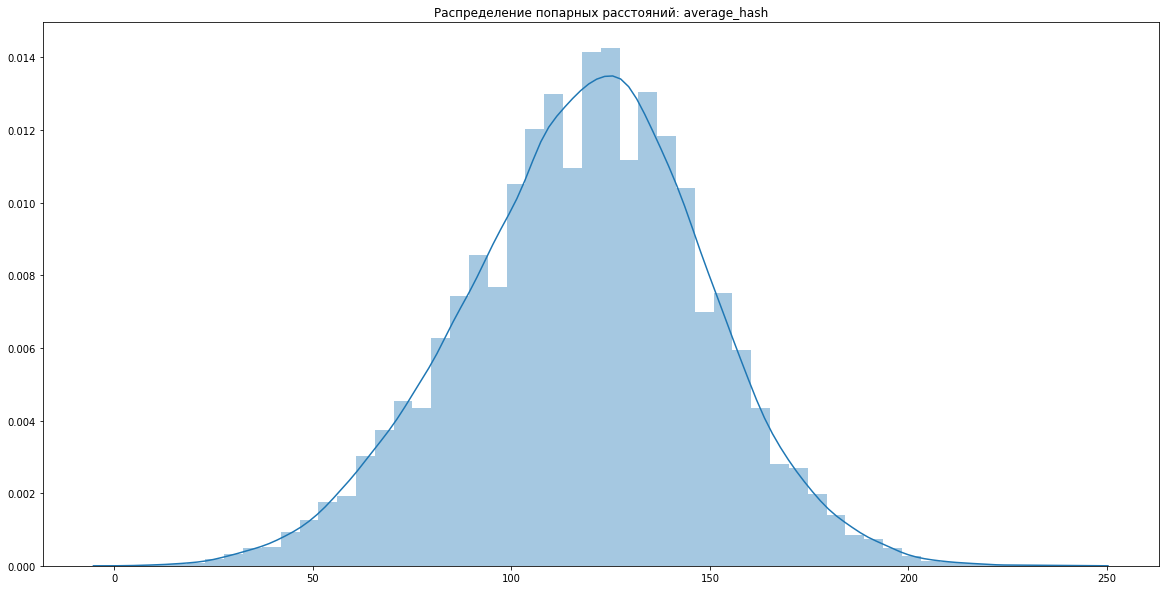

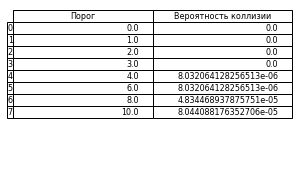

In [59]:
#image, hash_size=8
import pandas as pd
a = test_hasher(dataset_PIL, imagehash.average_hash,  name='Распределение попарных расстояний: average_hash', hash_size=16) 

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


(7.572456430003513,
 0.015144912860007026,
 {0: 0.0,
  1: 1.539879759519038e-05,
  2: 4.771943887775551e-05,
  3: 0.00011991983967935872,
  4: 0.00026312625250501004,
  6: 0.0010538917835671343,
  8: 0.0028692985971943887,
  10: 0.006550164328657315})

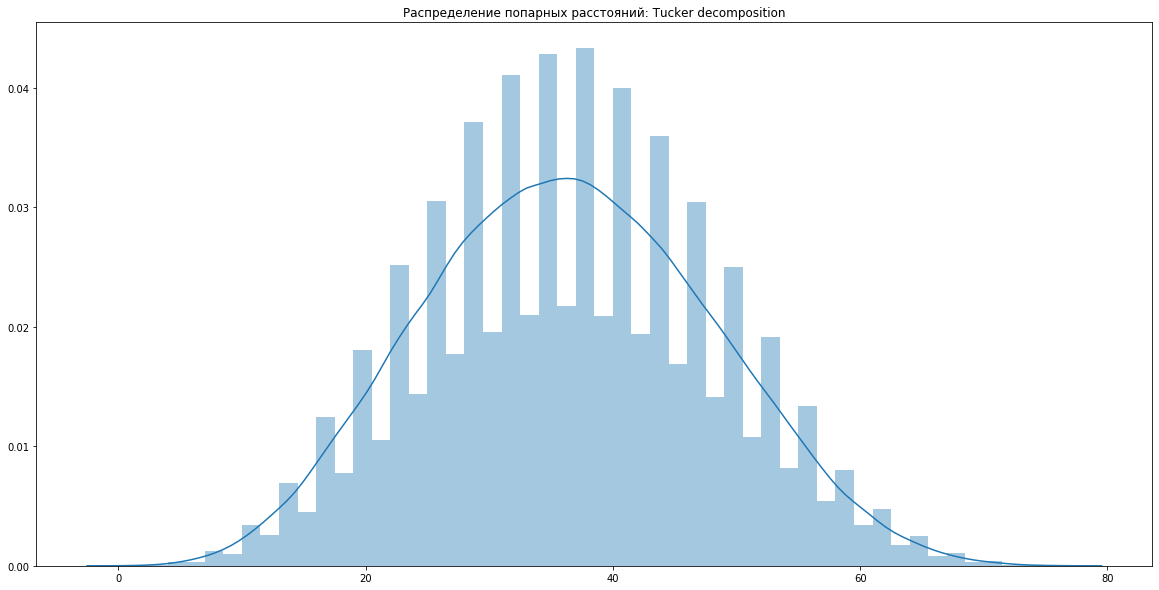

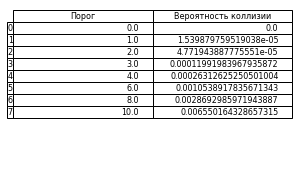

In [60]:
test_hasher(ucid_dataset_prepared, get_tucker_hash, name='Распределение попарных расстояний: Tucker decomposition', q_block_size=32, i_core=1, j_core=1, k_core=1) 

In [19]:
from pandas.tools.plotting import table


/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


(5.534891423012596,
 0.011069782846025191,
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  6: 0.0,
  8: 8.160320641282566e-06,
  10: 2.4200400801603205e-05})

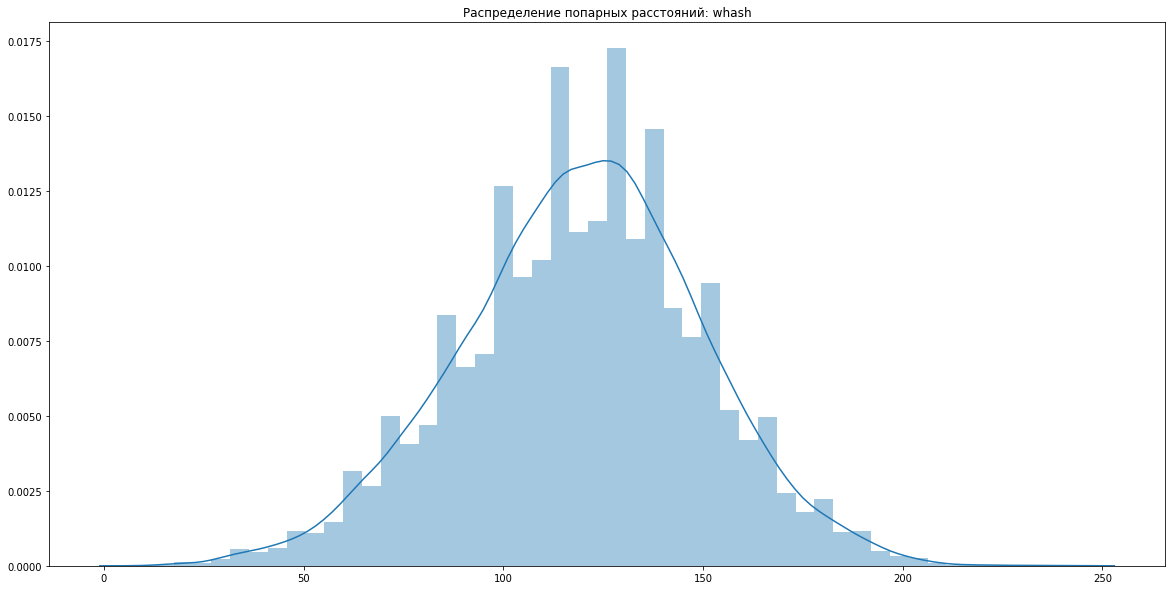

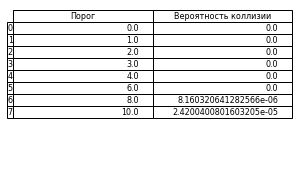

In [61]:
test_hasher(dataset_PIL, imagehash.whash, name='Распределение попарных расстояний: whash', hash_size=16) 

In [136]:
len(ucid_dataset_prepared)

500

In [23]:
kodak_images_clear = np.load('./data/kodak_images_clear.npy', allow_pickle=True)

In [24]:
len(kodak_images_clear)

24

In [26]:
from skimage import data, img_as_float, color

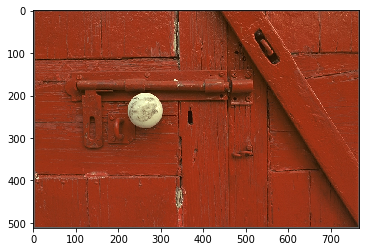

In [88]:
plt.imshow(kodak_images_clear[1])

In [87]:
 imagehash.whash(Image.fromarray(kodak_images_clear[0]))

array([[ True,  True,  True,  True, False,  True,  True,  True],
       [False, False,  True,  True, False,  True,  True, False],
       [False,  True,  True,  True, False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True, False,  True, False, False, False, False],
       [False,  True, False,  True, False, False, False, False],
       [False,  True, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False]])

In [27]:
kodak_images_rgb = np.load('./data/kodak_images_rgb_256x256.npy', allow_pickle=True)
kodak_images_L = np.load('./data/kodak_images_L_256x256.npy', allow_pickle=True)

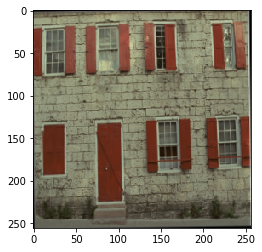

In [150]:
plt.imshow(kodak_images_rgb[0][3])

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


(7.799537865997991,
 0.015599075731995982,
 {0: 0.0,
  1: 1.539879759519038e-05,
  2: 4.771943887775551e-05,
  3: 0.00011991983967935872,
  4: 0.00026312625250501004,
  6: 0.0010538917835671343,
  8: 0.0028692985971943887,
  10: 0.006550164328657315})

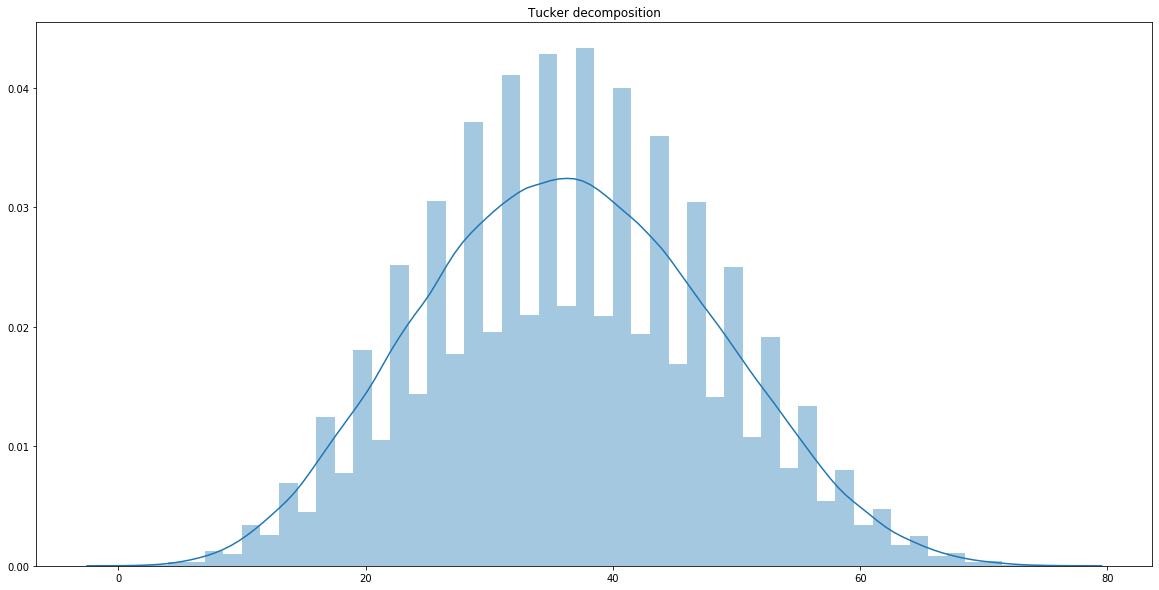

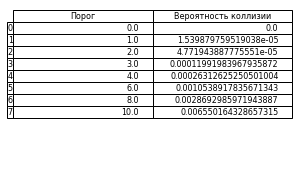

In [39]:
test_hasher(
    ucid_dataset_prepared,
    get_tucker_hash,
    name='Попарные расстояния: Tucker decomposition', q_block_size=32, i_core=1, j_core=1, k_core=1) 

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 6: 0.0,
 8: 0.042166666666666665,
 10: 0.1650833333333333}

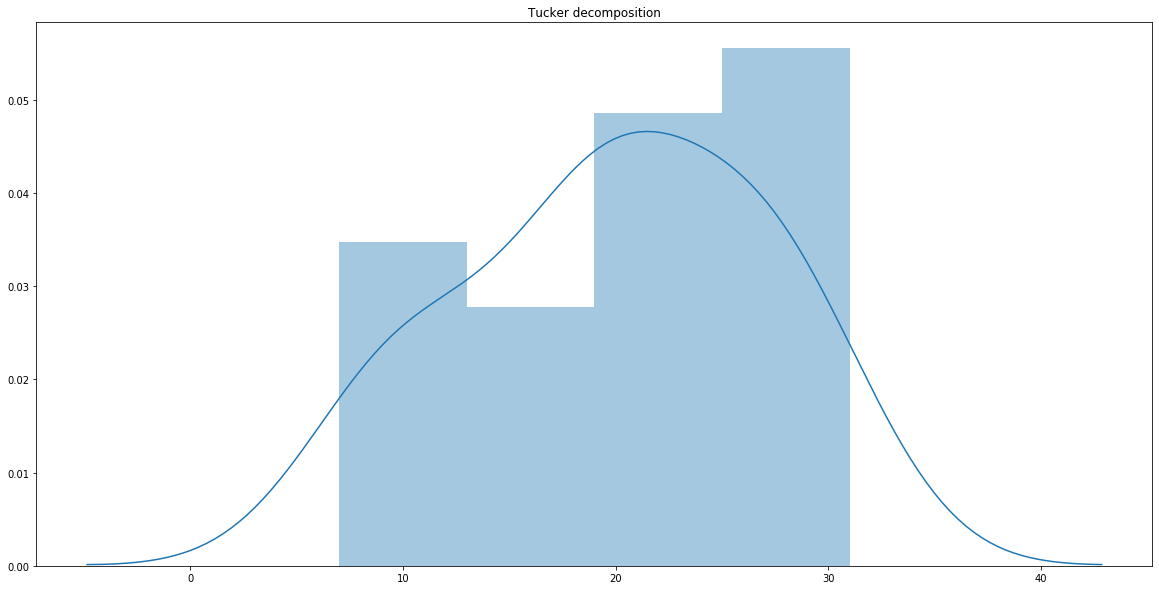

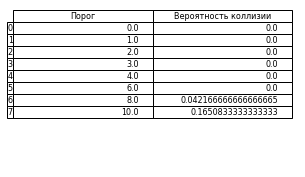

In [29]:
test_hasher_dist(
    kodak_images_L[:,0,:,:],
    kodak_images_L[:,20,:,:],
    get_tucker_hash,
    ima=False,
    name='Tucker decomposition', q_block_size=32, i_core=1, j_core=1, k_core=1) 

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 6: 0.0,
 8: 0.1683333333333333,
 10: 0.37566666666666665}

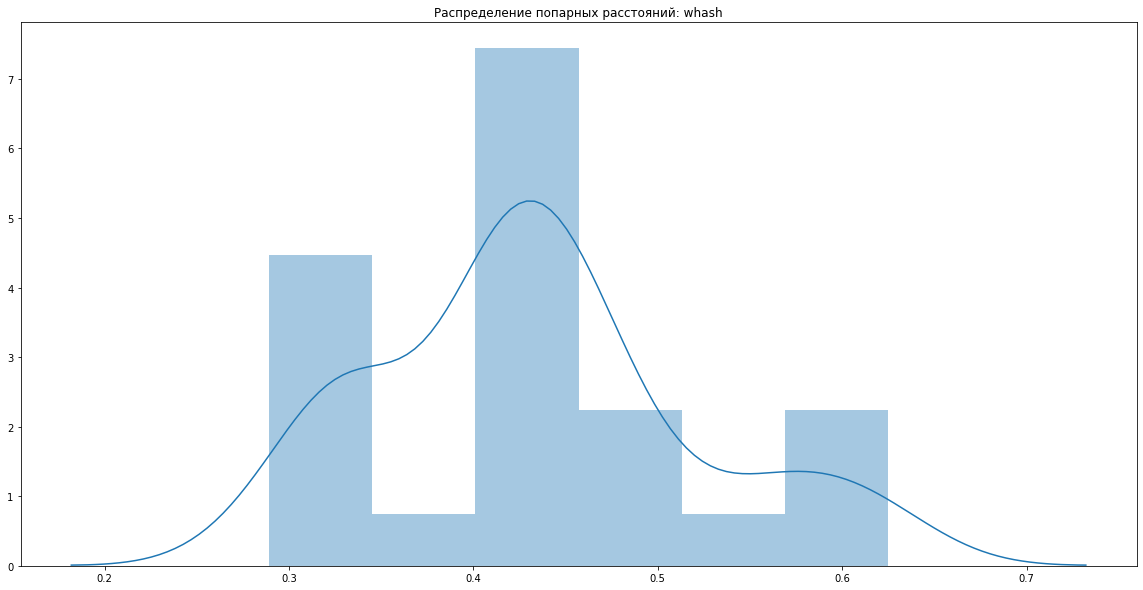

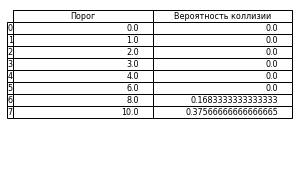

In [47]:
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,14,:,:], imagehash.whash, ima=True, name='Распределение попарных расстояний: whash', hash_size=16) 

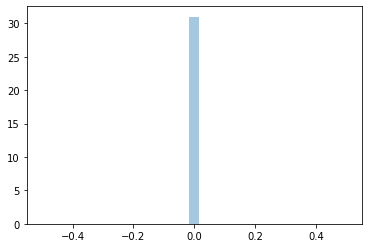

In [68]:
aaaa = list()
for i in range(1000):
    aaaa.append(hamming(
    get_tucker_hash(kodak_images_L[0,0,:,:], q_block_size=32, i_core=1, j_core=1, k_core=1),
    get_tucker_hash(kodak_images_L[0,0,:,:], q_block_size=32, i_core=1, j_core=1, k_core=1)))
sns.distplot(aaaa)

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.04091666666666667,
 4: 0.08195833333333334,
 6: 0.25133333333333335,
 8: 0.3785,
 10: 0.49820833333333336}

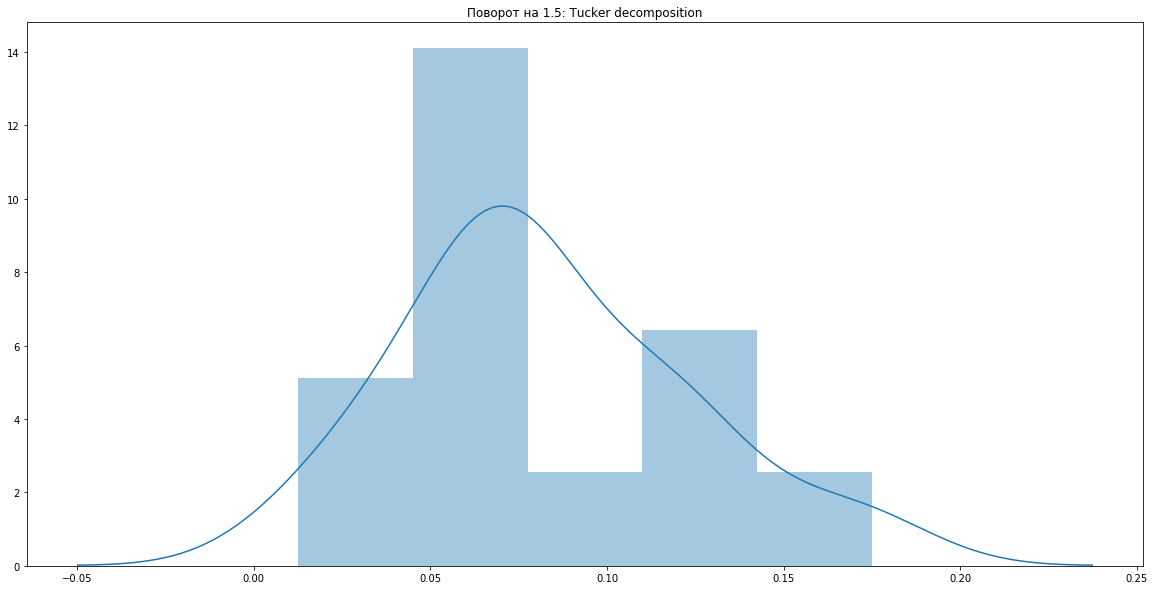

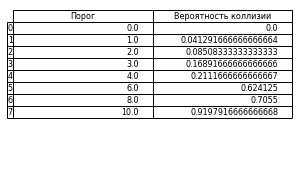

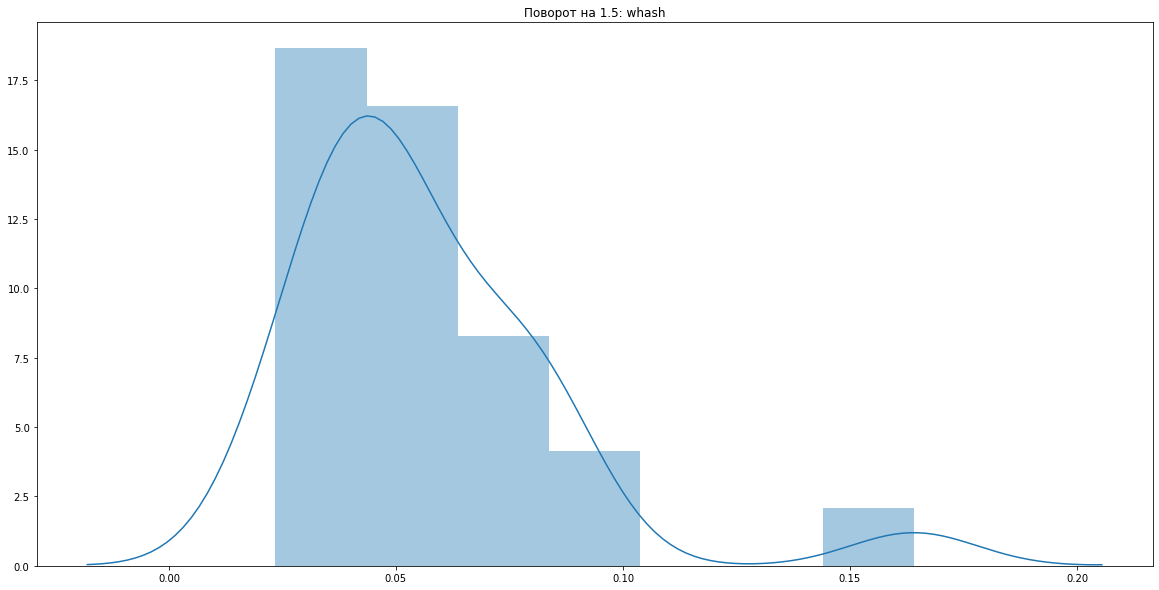

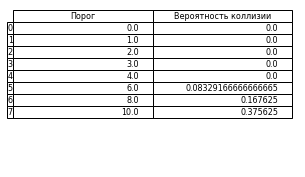

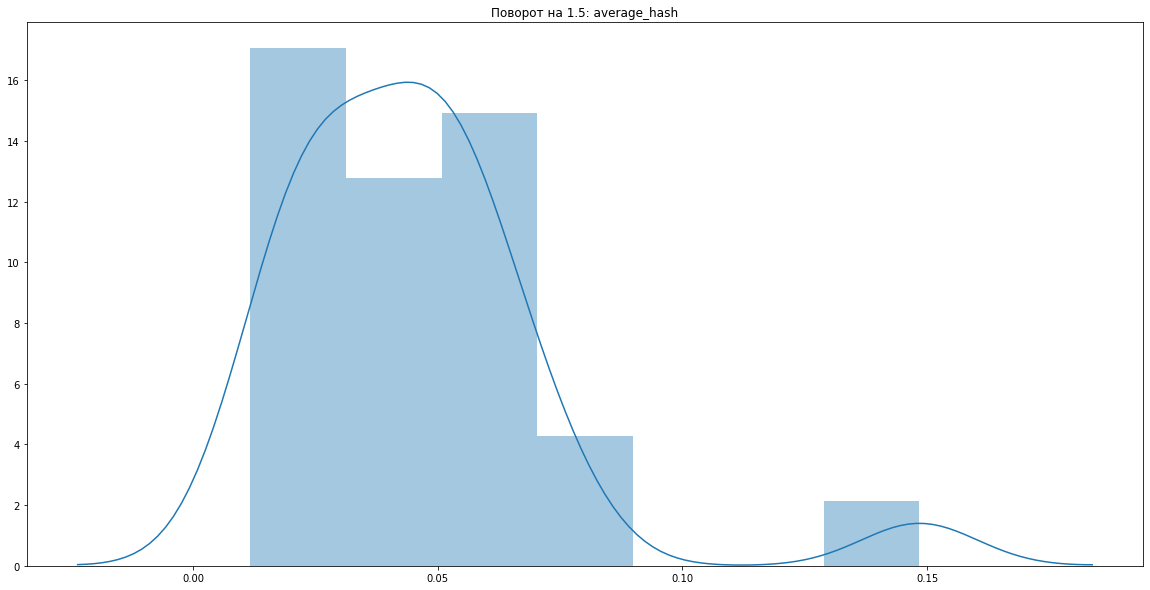

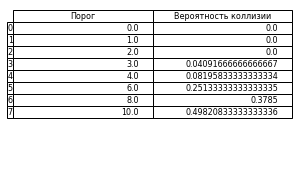

In [64]:
test_hasher_dist(
    kodak_images_L[:,0,:,:],
    kodak_images_L[:,6,:,:],
    get_tucker_hash,
    ima=False,
    name='Поворот на 1.5: Tucker decomposition', q_block_size=32, i_core=1, j_core=1, k_core=1)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,6,:,:], 
    imagehash.whash, ima=True, 
    name='Поворот на 1.5: whash', hash_size=16)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,6,:,:], 
    imagehash.average_hash, ima=True, 
    name='Поворот на 1.5: average_hash', hash_size=16) 

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0, 8: 0.0, 10: 0.0}

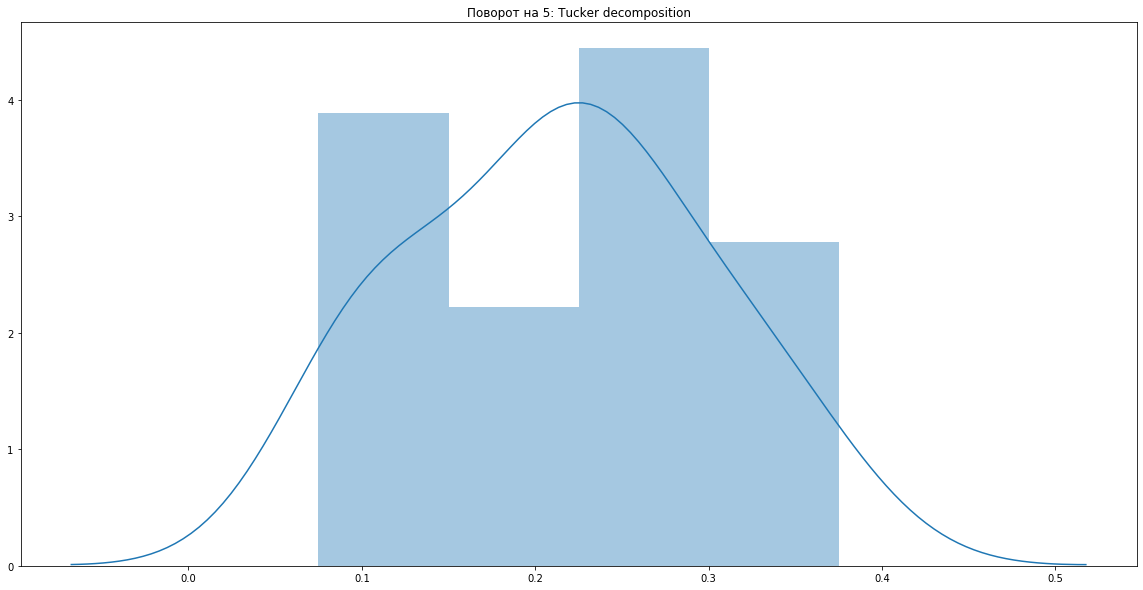

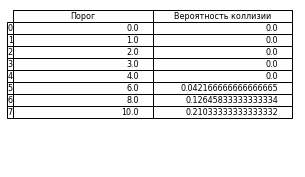

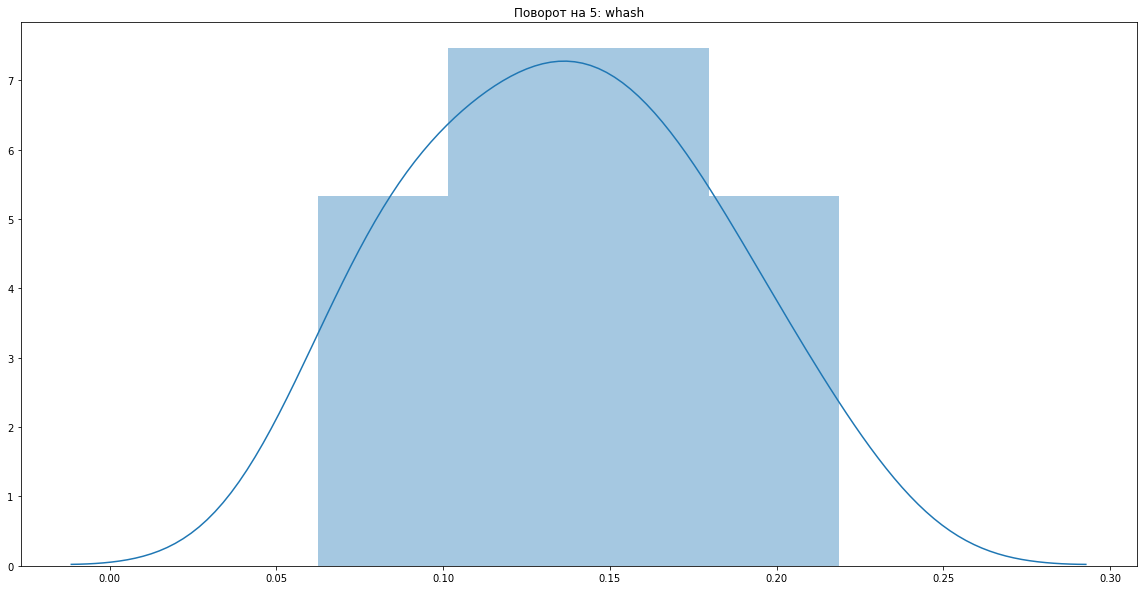

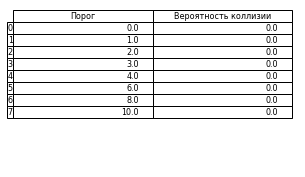

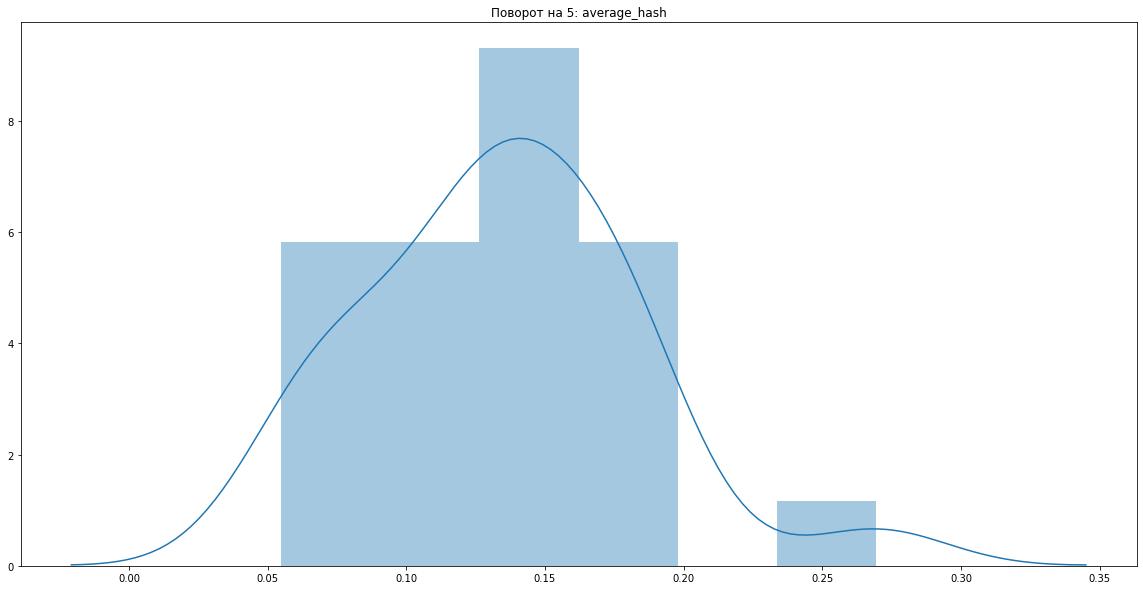

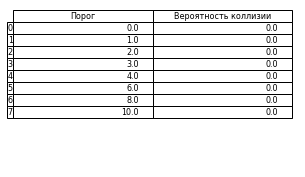

In [65]:
test_hasher_dist(
    kodak_images_L[:,0,:,:],
    kodak_images_L[:,10,:,:],
    get_tucker_hash,
    ima=False,
    name='Поворот на 5: Tucker decomposition', q_block_size=32, i_core=1, j_core=1, k_core=1)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,10,:,:], 
    imagehash.whash, ima=True, 
    name='Поворот на 5: whash', hash_size=16)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,10,:,:], 
    imagehash.average_hash, ima=True, 
    name='Поворот на 5: average_hash', hash_size=16) 

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0, 8: 0.0, 10: 0.0}

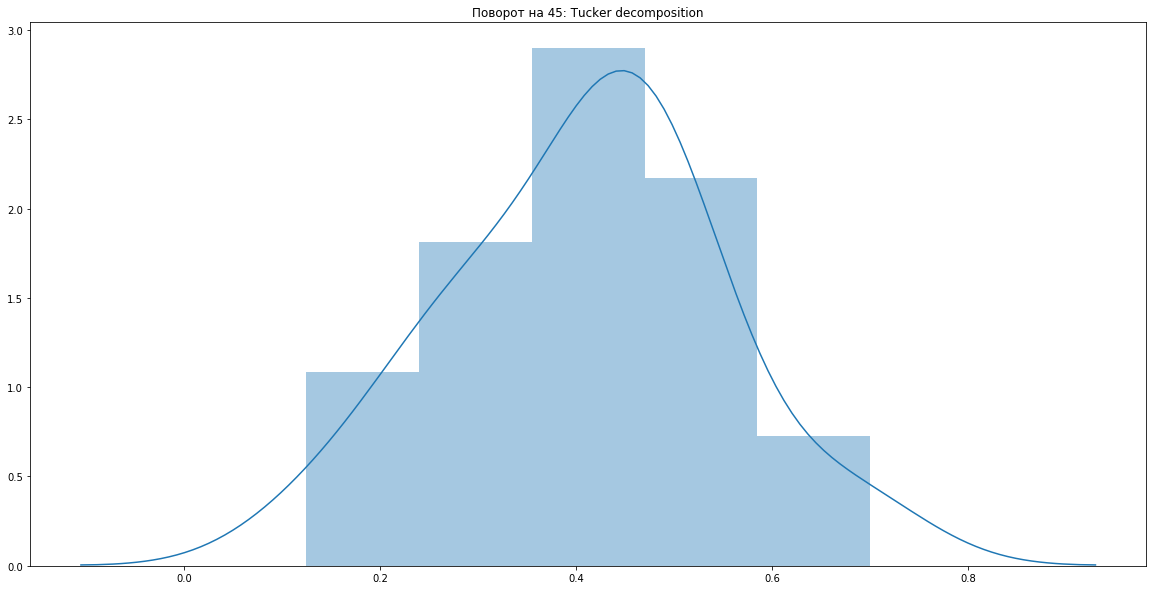

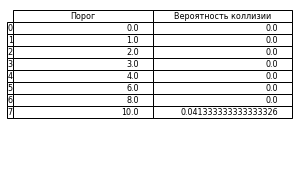

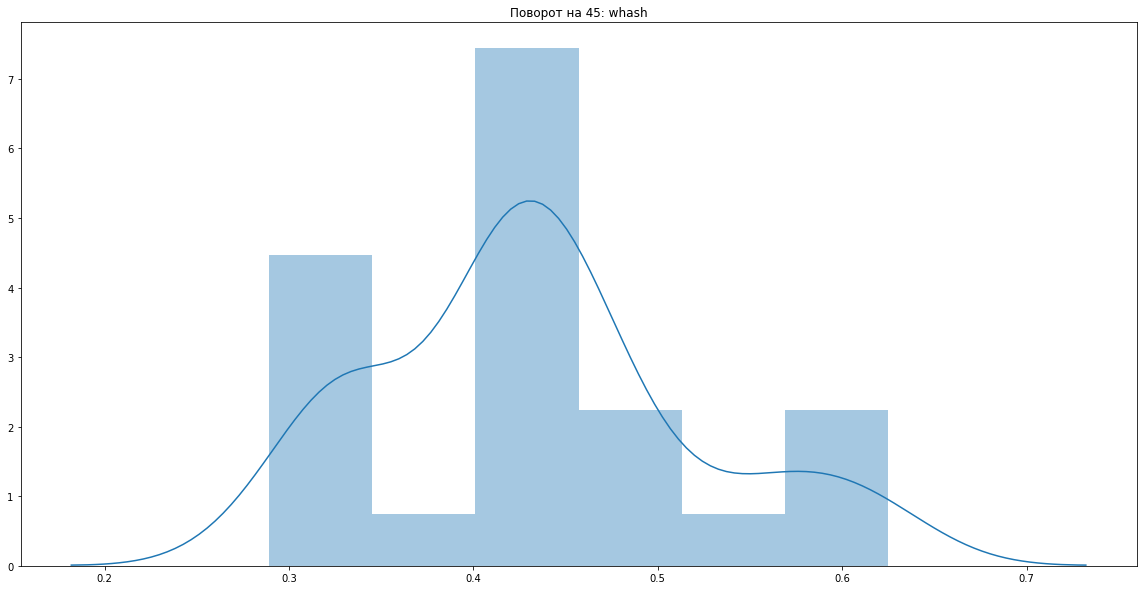

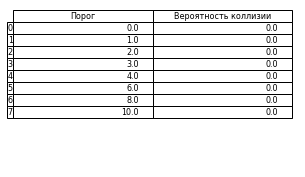

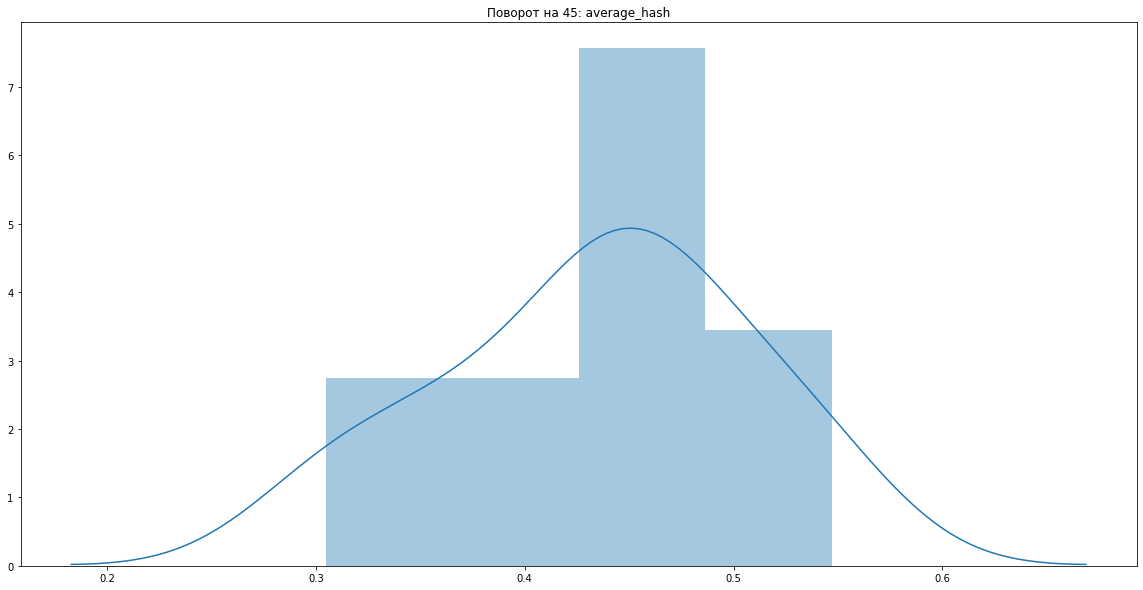

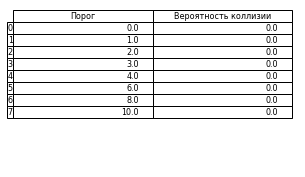

In [66]:
test_hasher_dist(
    kodak_images_L[:,0,:,:],
    kodak_images_L[:,14,:,:],
    get_tucker_hash,
    ima=False,
    name='Поворот на 45: Tucker decomposition', q_block_size=32, i_core=1, j_core=1, k_core=1)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,14,:,:], 
    imagehash.whash, ima=True, 
    name='Поворот на 45: whash', hash_size=16)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,14,:,:], 
    imagehash.average_hash, ima=True, 
    name='Поворот на 45: average_hash', hash_size=16) 

/home/marti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0, 8: 0.0, 10: 0.0}

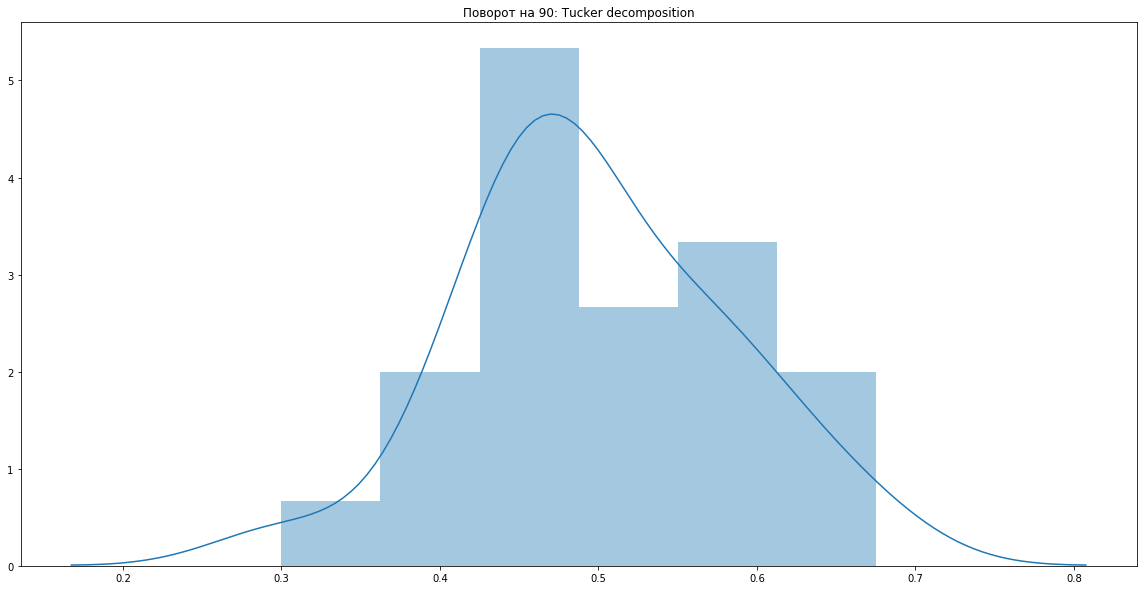

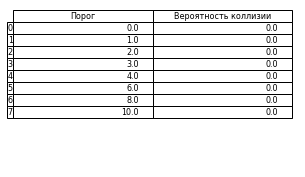

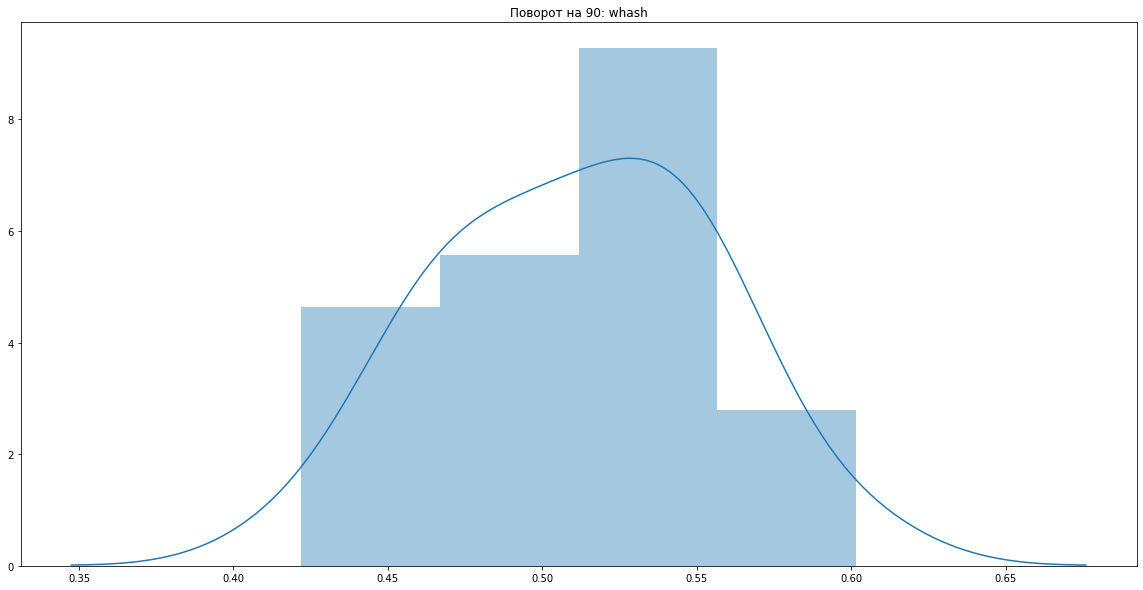

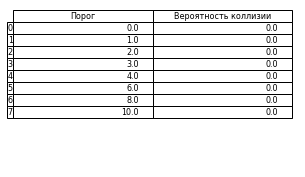

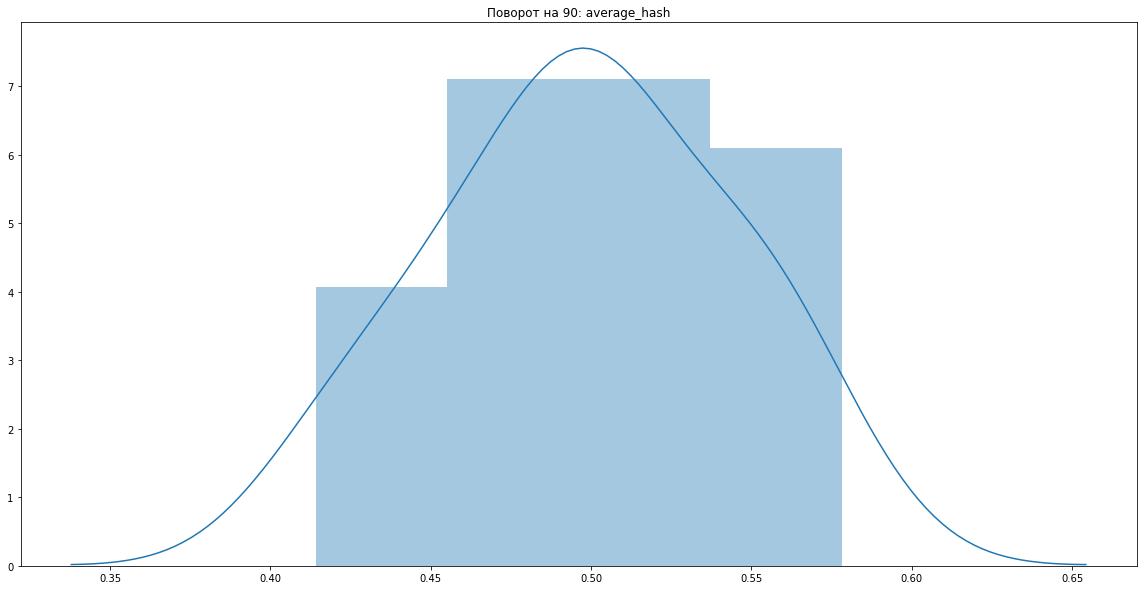

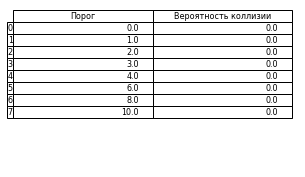

In [67]:
test_hasher_dist(
    kodak_images_L[:,0,:,:],
    kodak_images_L[:,16,:,:],
    get_tucker_hash,
    ima=False,
    name='Поворот на 90: Tucker decomposition', q_block_size=32, i_core=1, j_core=1, k_core=1)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,16,:,:], 
    imagehash.whash, ima=True, 
    name='Поворот на 90: whash', hash_size=16)
test_hasher_dist(kodak_images_rgb[:,0,:,:],
    kodak_images_rgb[:,16,:,:], 
    imagehash.average_hash, ima=True, 
    name='Поворот на 90: average_hash', hash_size=16) 